# Sentinel-2 NDVI and Agricultural Monitoring over Mar Menor

This notebook analyses Sentinel-2 optical imagery to monitor vegetation and agricultural activity in the Mar Menor region (SE Spain).
It computes NDVI composites and time series for selected areas, quantifies pixel-wise variance, and allows masking and visualization of vegetated zones.
A time series of mean NDVI for a sample field is generated and plotted. Outputs include NDVI maps, a time-series plot, and the option to export results as GeoTIFF.

Requirements: authenticated Google Earth Engine account and geemap installed for interactive mapping. Run the cells sequentially and expect remote calls (reduceRegion / getInfo) to take time.


In [1]:
# Imports and Earth Engine initialization
import ee
import geemap
import datetime

# Initialize the Earth Engine API (authenticate if needed)
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# Define the area of interest (Mar Menor bounding rectangle) and comparison periods
mar_menor_aoi = ee.Geometry.Polygon([
    [
        [-0.7525010397061688, 37.88948999937322],
        [-0.8060344170800802, 37.89141594762948],
        [-0.9369668300256822, 37.84237282648271],
        [-1.0082296404312558, 37.769738583926646],
        [-1.0376769713508793, 37.74073202619191],
        [-1.0341435939769678, 37.68720630363401],
        [-1.0102841247516163, 37.65777126035968],
        [-0.9189328193280476, 37.55604663597647],
        [-0.718559540295739, 37.60522151419349],
        [-0.6905554748006199, 37.63584518455255],
        [-0.7525010397061688, 37.88948999937322] 
    ]
])

# Define objective time periods
obj_date = '2019-09-15'
obj_date_dt = datetime.datetime.strptime(obj_date, "%Y-%m-%d")
start_date = (obj_date_dt - datetime.timedelta(days=20)).strftime("%Y-%m-%d")
end_date = (obj_date_dt + datetime.timedelta(days=20)).strftime("%Y-%m-%d")

### Collection preparation and edge masking
Create the Sentinel-2 collection for the AOI and period of interest, filtering by cloud cover and spatial bounds. Although edge masking is more critical for SAR data, a simple maskEdge function is included for completeness and to maintain consistency with other analyses. You can check the collection size after running and adjust filters or masking as needed to optimize the quality of the composites.

In [2]:

# Function to mask the edges of Sentinel-1 images (improves quality)
def maskEdge(image):
    edge = image.lt(-30.0)
    maskedImage = image.mask().And(edge.Not())
    return image.updateMask(maskedImage)

# Load Sentinel-2 data
sentinel2_base_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR')  # Use the Sentinel-2 Surface Reflectance collection
    .filterBounds(mar_menor_aoi)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Filter images with less than 20% clouds
)

C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ee\deprecation.py:209: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


### Filtering the Sentinel-2 collection for the 2019 summer season

For this analysis, we focus on the summer of 2019. The Sentinel-2 image collection is filtered for this period and the area of interest. We select images matching the date range and spatial bounds, then compute the median composite to reduce cloud and noise effects. This provides a representative image for the 2019 season, which will be used for NDVI and land cover analysis.

In [3]:

# Filter the collection for summer 2019 and calculate the median
verano_2019_collection = sentinel2_base_collection.filterDate(start_date, end_date)
verano_2019_median = verano_2019_collection.median().clip(mar_menor_aoi)

### NDVI as an intermediate analysis layer

The NDVI is calculated here as an intermediate product to support further analysis, rather than as a final layer for the main map viewer. By running the next cell, you can preview the NDVI for the selected period and area, which helps to quickly assess vegetation patterns before more advanced processing or visualization steps.

In [4]:

# Visualize the image
# True color visualization (bands 4=Red, 3=Green, 2=Blue)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Take the first image from the summer 2019 collection
una_imagen_2019 = ee.Image(verano_2019_collection.first())

# Calculate NDVI
ndvi_2019 = una_imagen_2019.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Visualization: gray for low NDVI (<0.2), green gradient for high NDVI
ndvi_vis = {
    'min': 0.0,
    'max': 1.0,
    'palette': ['black', 'green', 'lightgreen', 'white']
}

m = geemap.Map(center=[37.75, -0.85], zoom=11)
m.addLayer(ndvi_2019, ndvi_vis, 'NDVI: gray=no vegetation, green=vegetation')
m.addLayerControl()
display(m)

Map(center=[37.75, -0.85], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

### Pixel-wise variance map calculation

To assess spatial variability in vegetation vigor, we compute the variance of the Sentinel-2 near-infrared band (B8) across the image collection for the selected period. The process involves calculating NDVI for each image, masking out non-vegetated areas, and then computing the variance only where vegetation is present. The resulting map highlights areas with greater temporal changes in vegetation, which can indicate the use of fertilizers. This is a general technique that can be further refined to improve precision, for example by adjusting the vegetation mask or analyzing specific crop types.

In [5]:
# 1. Calculate NDVI for each image in the collection
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

sentinel2_ndvi_collection = sentinel2_base_collection.map(add_ndvi)

# 2. Calculate the mean NDVI for the period
ndvi_mean = sentinel2_ndvi_collection.select('NDVI').mean().clip(mar_menor_aoi)

# 3. Create a mask for areas with high mean NDVI (e.g., > 0.3)
vegetacion_mask = ndvi_mean.gt(0.25)

# 4. Calculate the variance of band B8 only in vegetated areas
varianza_b8 = sentinel2_base_collection.select('B8').reduce(ee.Reducer.variance()).clip(mar_menor_aoi)
varianza_b8_vegetacion = varianza_b8.updateMask(vegetacion_mask)

# 5. Visualize only the variance in vegetated areas
varianza_vis = {
    'min': 1000,
    'max': 2500000,
    'palette': ['lightgreen', 'green', 'darkgreen', 'black']
}

m = geemap.Map(center=[37.75, -0.85], zoom=11)
m.addLayer(varianza_b8_vegetacion, varianza_vis, 'B8 Variance (vegetation only)')
m.addLayerControl()
display(m)

Map(center=[37.75, -0.85], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

### Field-level NDVI time series for monitoring

In this final cell, we extract NDVI data for a specific agricultural field within the study area. This allows us to plot the NDVI time series and evaluate the vegetation history of the field. Such an analysis simulates a real-world use case for authorities or land managers, who may want to monitor crop health, detect anomalies, or assess compliance with agricultural practices over time.

['2018-01-01', '2018-01-11', '2018-01-16', '2018-01-21', '2018-01-31', '2018-02-15', '2018-02-20', '2018-03-07', '2018-03-12', '2018-03-22', '2018-03-27', '2018-04-01']
[np.float64(-0.08328981786362773), np.float64(-0.06474972303989499), np.float64(-0.037170438896150376), np.float64(-0.03518483662586792), np.float64(-0.0008077706935749399), np.float64(-0.07180198567000204), np.float64(-0.09971659499423496), np.float64(-0.0411351667712329), np.float64(-0.09620998608894712), np.float64(-0.08058673876552158), np.float64(0.01753852212397357), np.float64(0.07114218451188951)]


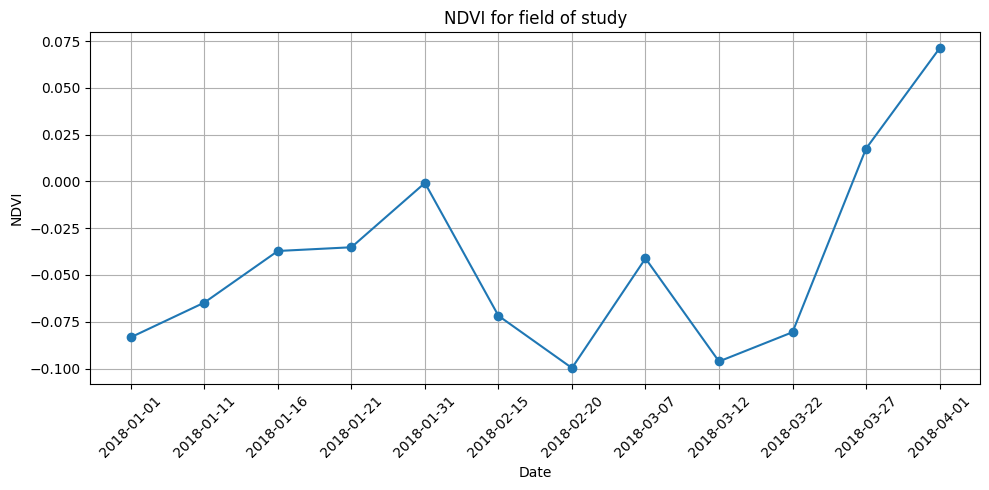

In [14]:
field_aoi = ee.Geometry.Polygon([
    [
    [-0.8988042244258093, 37.689694748180386],
    [-0.8929406467702561, 37.69277176698362],
    [-0.8908297588142571, 37.688815576499955],
    [37.686744597528715, -0.8970389789145817],
    [-0.8590951030363295, 37.789575370980444],
    ]
])

import matplotlib.pyplot as plt

# Set target date
obj_date = '2018-2-19'# '2023-11-1'
obj_date_dt = datetime.datetime.strptime(obj_date, "%Y-%m-%d")

# Calculate start and end dates
start_date = (obj_date_dt - datetime.timedelta(days=50)).strftime("%Y-%m-%d")
end_date = (obj_date_dt + datetime.timedelta(days=50)).strftime("%Y-%m-%d")

# Load Sentinel-2 collection
sentinel2_base_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR')  # Use Sentinel-2 Surface Reflectance collection
    .filterBounds(mar_menor_aoi)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Filter images with less than 30% clouds
)

# Calculate NDVI for each image in the collection
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

sentinel2_ndvi_collection = sentinel2_base_collection.map(add_ndvi)

# Get mean NDVI for the field
def get_ndvi_mean(image):
    mean = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=field_aoi,
        scale=10,
        maxPixels=1e9
).get('NDVI')
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'ndvi': mean
    })

ndvi_time_series = sentinel2_ndvi_collection.map(get_ndvi_mean).filter(
    ee.Filter.notNull(['ndvi'])
)

# Download NDVI and dates to Python
ndvi_dict = ndvi_time_series.aggregate_array('ndvi').getInfo()
dates = ndvi_time_series.aggregate_array('date').getInfo()

# Create a list of unique dates and average NDVI for each date
import numpy as np
ndvi_means = [np.mean(ndvi_dict[i:i+2]) for i in range(0, len(ndvi_dict), 2)]
dates_unique = [dates[i] for i in range(0, len(dates), 2)]

# Print results
print(dates_unique)
print(ndvi_means)

# Plot the grouped time series
plt.figure(figsize=(10,5))
plt.plot(dates_unique, ndvi_means, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI for field of study')
plt.grid(True)
plt.tight_layout()
plt.show()